In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
random_state = 0

# IMPORT DATASET

In [4]:
dataset_path = parentdir + "/datasets/EpilepticSeizureRecognition/"

In [5]:
dataset_name = "EpilepticSeizureRecognition"

In [64]:
X = pd.read_csv(dataset_path + "data.csv", index_col = 0)
y = np.array(X["y"])
y_all = np.ravel(y).astype("int")
for i in range(2,6):
    y_all[y_all == i] = 2
le = LabelEncoder()
le.fit(y_all)
y_all = le.transform(y_all)
X_all = X.drop("y", axis = 1).values

In [65]:
from imblearn.under_sampling import RandomUnderSampler # doctest: +NORMALIZE_WHITESPACE
rus = RandomUnderSampler(random_state=random_state, )
X_all, y_all = rus.fit_resample(X_all, y_all)

X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

In [66]:
print("X SHAPE: ", X_all.shape)
print("y SHAPE: ", y_all.shape)
unique, counts = np.unique(y_all, return_counts=True)
print("\nCLASSES BALANCE")
for i, label in enumerate(unique):
    print(label, ": ", round(counts[i]/sum(counts), 2))

X SHAPE:  (4600, 178, 1)
y SHAPE:  (4600,)

CLASSES BALANCE
0 :  0.5
1 :  0.5


## DATASET SPLIT

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
# BLACKBOX TRAIN/TEST SETS SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                  test_size=0.2, stratify = y_all, random_state=random_state)

# BLACKBOX/EXPLANATION SETS SPLIT
X_train, X_exp, y_train, y_exp = train_test_split(X_train, y_train, 
                                                  test_size=0.3, stratify = y_train, random_state=random_state)

# BLACKBOX TRAIN/VALIDATION SETS SPLIT
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# EXPLANATION TRAIN/TEST SETS SPLIT
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y_exp, 
                                                                    test_size=0.2, 
                                                                    stratify = y_exp, 
                                                                    random_state=random_state)

# EXPLANATION TRAIN/VALIDATION SETS SPLIT
X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(X_exp_train, y_exp_train, 
                                                                  test_size=0.2, 
                                                                  stratify = y_exp_train, 
                                                                  random_state=random_state)

print("SHAPES:")
print("BLACKBOX TRAINING SET: ", X_train.shape)
print("BLACKBOX VALIDATION SET: ", X_val.shape)
print("BLACKBOX TEST SET: ", X_test.shape)
print("EXPLANATION TRAINING SET: ", X_exp_train.shape)
print("EXPLANATION VALIDATION SET: ", X_exp_val.shape)
print("EXPLANATION TEST SET: ", X_exp_test.shape)

SHAPES:
BLACKBOX TRAINING SET:  (2060, 178, 1)
BLACKBOX VALIDATION SET:  (516, 178, 1)
BLACKBOX TEST SET:  (920, 178, 1)
EXPLANATION TRAINING SET:  (706, 178, 1)
EXPLANATION VALIDATION SET:  (177, 178, 1)
EXPLANATION TEST SET:  (221, 178, 1)


In [69]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_all)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  178
N. LABELS:  2


# BLACKBOX MODEL

In [70]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import UpSampling1D
from keras import optimizers
from keras.models import Model
from keras import backend as K
from keras.layers import Dropout
from keras.layers import Reshape
from keras.utils import to_categorical
import time

In [71]:
from blackboxes import *

In [72]:
import blackboxes

In [22]:
import importlib
importlib.reload(blackboxes)

<module 'blackboxes' from '/Users/francesco/github/TS_AgnosticLocalExplainer/blackboxes.py'>

## resnet

In [97]:
blackbox = build_resnet(n_timesteps, n_outputs)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
file_path = parentdir + "/blackbox_checkpoints/" + dataset_name + "_blackbox_resnet_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_acc:.2f}_.hdf5")

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_acc', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)

callbacks = [reduce_lr, model_checkpoint]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [98]:
blackbox.fit(X_train, y_train, epochs=100, batch_size=mini_batch_size, callbacks = callbacks,
             validation_data=(X_val, y_val))

Train on 2060 samples, validate on 516 samples
Epoch 1/100
2060/2060 [==============================] - 106s 52ms/step - loss: 0.2074 - acc: 0.9131 - val_loss: 0.1355 - val_acc: 0.9496

Epoch 00001: val_acc improved from -inf to 0.94961, saving model to /Users/francesco/github/TS_AgnosticLocalExplainer/blackbox_checkpoints/EpilepticSeizureRecognition_blackbox_resnet_20200105_233014_best_weights_+0.95_.hdf5
Epoch 2/100
2060/2060 [==============================] - 88s 43ms/step - loss: 0.1565 - acc: 0.9393 - val_loss: 0.1714 - val_acc: 0.9748

Epoch 00002: val_acc improved from 0.94961 to 0.97481, saving model to /Users/francesco/github/TS_AgnosticLocalExplainer/blackbox_checkpoints/EpilepticSeizureRecognition_blackbox_resnet_20200105_233014_best_weights_+0.97_.hdf5
Epoch 3/100
2060/2060 [==============================] - 87s 42ms/step - loss: 0.1717 - acc: 0.9320 - val_loss: 0.2003 - val_acc: 0.9516

Epoch 00003: val_acc did not improve from 0.97481
Epoch 4/100
2060/2060 [==============

2060/2060 [==============================] - 127s 61ms/step - loss: 0.0430 - acc: 0.9845 - val_loss: 0.0579 - val_acc: 0.9845

Epoch 00038: val_acc did not improve from 0.99419
Epoch 39/100
2060/2060 [==============================] - 104s 50ms/step - loss: 0.0508 - acc: 0.9811 - val_loss: 0.0339 - val_acc: 0.9884

Epoch 00039: val_acc did not improve from 0.99419
Epoch 40/100
2060/2060 [==============================] - 98s 48ms/step - loss: 0.0418 - acc: 0.9854 - val_loss: 0.0455 - val_acc: 0.9864

Epoch 00040: val_acc did not improve from 0.99419
Epoch 41/100
2060/2060 [==============================] - 89s 43ms/step - loss: 0.0394 - acc: 0.9840 - val_loss: 0.0557 - val_acc: 0.9826

Epoch 00041: val_acc did not improve from 0.99419
Epoch 42/100
1296/2060 [=================>............] - ETA: 29s - loss: 0.0470 - acc: 0.9830

KeyboardInterrupt: 

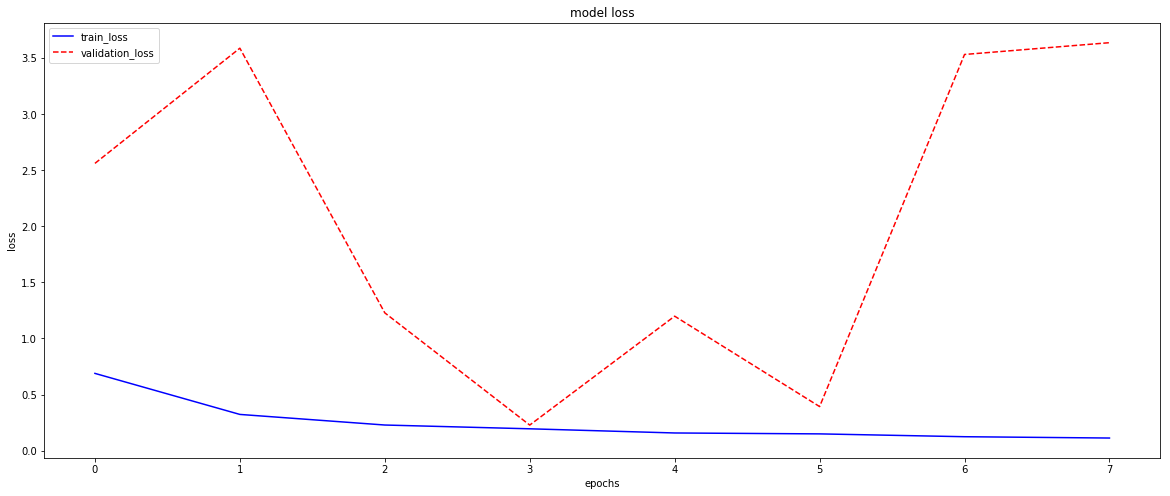

In [47]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(blackbox.history.history["loss"], color = "blue", label = "train_loss")
plt.plot(blackbox.history.history["val_loss"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

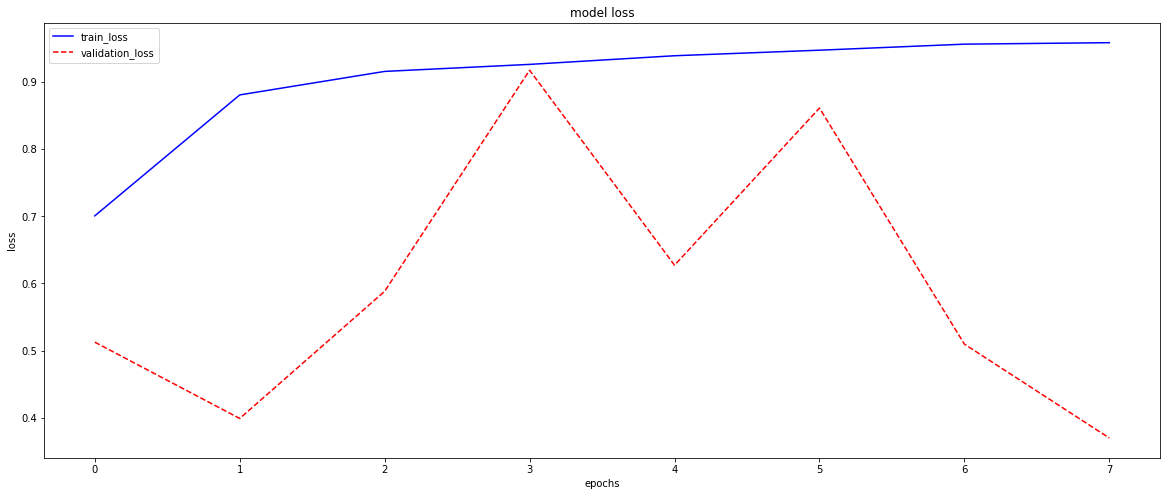

In [48]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(blackbox.history.history["acc"], color = "blue", label = "train_loss")
plt.plot(blackbox.history.history["val_acc"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

### load best weights

In [104]:
blackbox.load_weights(parentdir + "/blackbox_checkpoints/EpilepticSeizureRecognition_blackbox_resnet_20200105_233014_best_weights_+0.99_.hdf5")

In [105]:
blackbox.evaluate(X_test, y_test)

920/920 [==============================] - 15s 17ms/step


[0.05282546770151542, 0.9782608695652174]

In [106]:
resnet = blackbox

## simple CNN

In [122]:
blackbox = build_simple_CNN(n_timesteps, n_outputs)
blackbox.summary()
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
file_path = parentdir + "/blackbox_checkpoints/" + dataset_name + "_blackbox_simpleCNN_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_acc:.2f}_.hdf5")

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_acc', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)

callbacks = [reduce_lr, model_checkpoint]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 171, 16)           144       
_________________________________________________________________
batch_normalization_67 (Batc (None, 171, 16)           64        
_________________________________________________________________
activation_70 (Activation)   (None, 171, 16)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 171, 16)           0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 167, 32)           2592      
_________________________________________________________________
batch_normalization_68 (Batc (None, 167, 32)           128       
_________________________________________________________________
activation_71 (Activation)   (None, 167, 32)          

In [92]:
blackbox.fit(X_train, y_train, epochs=50, batch_size=mini_batch_size, callbacks = callbacks,
             validation_data=(X_val, y_val))

Train on 2060 samples, validate on 516 samples
Epoch 1/50
2060/2060 [==============================] - 11s 5ms/step - loss: 0.1177 - acc: 0.9568 - val_loss: 0.1113 - val_acc: 0.9496

Epoch 00001: val_acc did not improve from 0.97481
Epoch 2/50
2060/2060 [==============================] - 10s 5ms/step - loss: 0.0916 - acc: 0.9670 - val_loss: 0.1044 - val_acc: 0.9709

Epoch 00002: val_acc did not improve from 0.97481
Epoch 3/50
2060/2060 [==============================] - 11s 5ms/step - loss: 0.0896 - acc: 0.9675 - val_loss: 0.1044 - val_acc: 0.9612

Epoch 00003: val_acc did not improve from 0.97481
Epoch 4/50
2060/2060 [==============================] - 11s 5ms/step - loss: 0.1087 - acc: 0.9563 - val_loss: 0.1228 - val_acc: 0.9496

Epoch 00004: val_acc did not improve from 0.97481
Epoch 5/50
2060/2060 [==============================] - 10s 5ms/step - loss: 0.0927 - acc: 0.9675 - val_loss: 0.1136 - val_acc: 0.9554

Epoch 00005: val_acc did not improve from 0.97481
Epoch 6/50
2060/2060 [=


Epoch 00042: val_acc did not improve from 0.98062
Epoch 43/50
2060/2060 [==============================] - 11s 5ms/step - loss: 0.0723 - acc: 0.9733 - val_loss: 0.0695 - val_acc: 0.9806

Epoch 00043: val_acc did not improve from 0.98062
Epoch 44/50
2060/2060 [==============================] - 11s 5ms/step - loss: 0.0746 - acc: 0.9704 - val_loss: 0.0892 - val_acc: 0.9632

Epoch 00044: val_acc did not improve from 0.98062
Epoch 45/50
2060/2060 [==============================] - 12s 6ms/step - loss: 0.0836 - acc: 0.9733 - val_loss: 0.0859 - val_acc: 0.9709

Epoch 00045: val_acc did not improve from 0.98062
Epoch 46/50
2060/2060 [==============================] - 11s 5ms/step - loss: 0.0834 - acc: 0.9723 - val_loss: 0.0781 - val_acc: 0.9748

Epoch 00046: val_acc did not improve from 0.98062
Epoch 47/50
2060/2060 [==============================] - 11s 5ms/step - loss: 0.0727 - acc: 0.9748 - val_loss: 0.0784 - val_acc: 0.9748

Epoch 00047: val_acc did not improve from 0.98062
Epoch 48/50
20

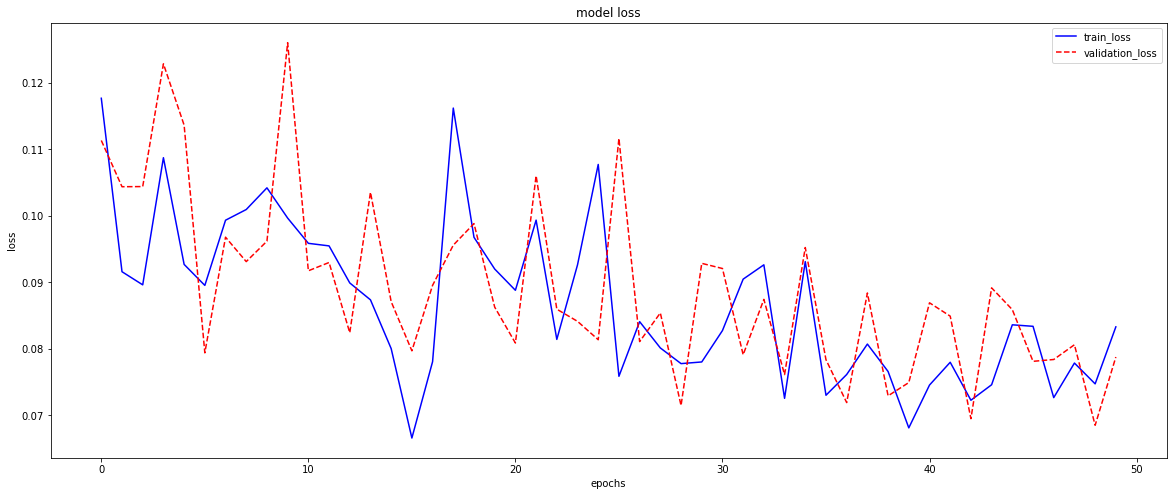

In [95]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(blackbox.history.history["loss"], color = "blue", label = "train_loss")
plt.plot(blackbox.history.history["val_loss"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

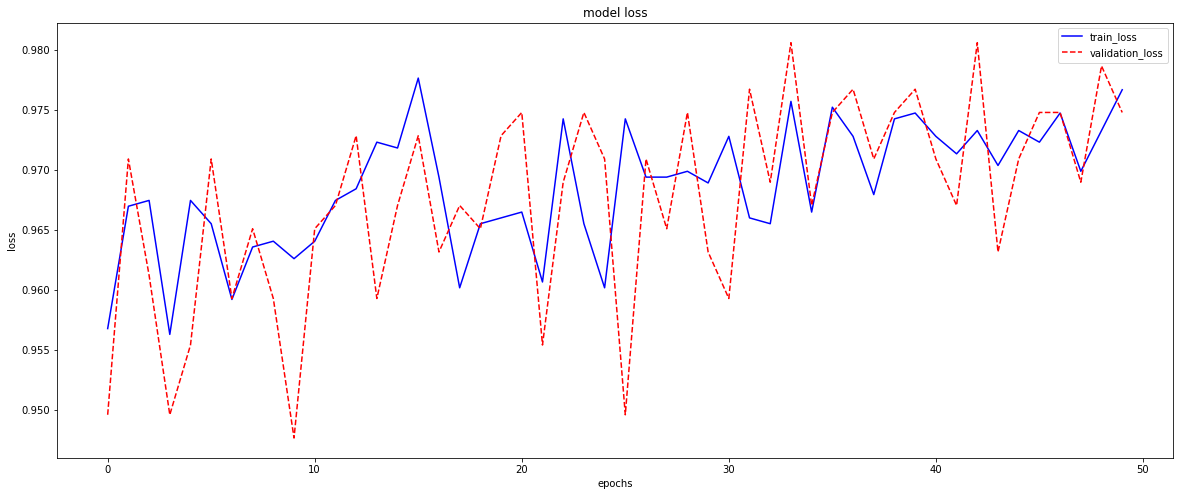

In [96]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(blackbox.history.history["acc"], color = "blue", label = "train_loss")
plt.plot(blackbox.history.history["val_acc"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

### load best weights

In [123]:
blackbox.load_weights(parentdir + "/blackbox_checkpoints/EpilepticSeizureRecognition_blackbox_simpleCNN_20200105_225722_best_weights_+0.98_.hdf5")

In [124]:
blackbox.evaluate(X_test, y_test)

920/920 [==============================] - 3s 4ms/step


[0.08075603249928226, 0.9717391304347827]

In [125]:
simplecnn = blackbox

## KNN

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

### grid search

In [74]:
#metriche usate nella grid search
scoring = {'MSE':make_scorer(mean_squared_error, greater_is_better=False), 'Accuracy': make_scorer(accuracy_score)}

#iperparametri
n_neighbors = list(range(1, 100))
metric = ["euclidean", "manhattan"]
#weights = ['uniform', 'distance']
weights = ['distance']
param_grid = dict(n_neighbors = n_neighbors, weights = weights, metric = metric)

#Definition of algorithm and GridSearch
knn = KNeighborsClassifier(algorithm='auto')
cv = StratifiedKFold(random_state=random_state, n_splits=3)
grid = GridSearchCV(knn, param_grid = param_grid, cv = cv, scoring = scoring, n_jobs=-1, 
                    return_train_score=True, refit='MSE', verbose=1)

In [75]:
%%time
grid.fit(X_train.reshape(X_train.shape[:2]), y_train)
results = grid.cv_results_

Fitting 3 folds for each of 198 candidates, totalling 594 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.1min


CPU times: user 2.44 s, sys: 363 ms, total: 2.8 s
Wall time: 11min 28s


[Parallel(n_jobs=-1)]: Done 594 out of 594 | elapsed: 11.5min finished


In [76]:
grid.best_params_

{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}

In [77]:
df_results = pd.DataFrame(results)

In [78]:
df_results.at[grid.best_index_, 'mean_test_Accuracy']

0.8538834951456311

In [79]:
# creo un datframe per ogni misura di distanza
df_results = df_results.sort_index()
df_per_metric = []
for distance in metric:
    df_per_metric.append(df_results[df_results["param_metric"] == distance])  

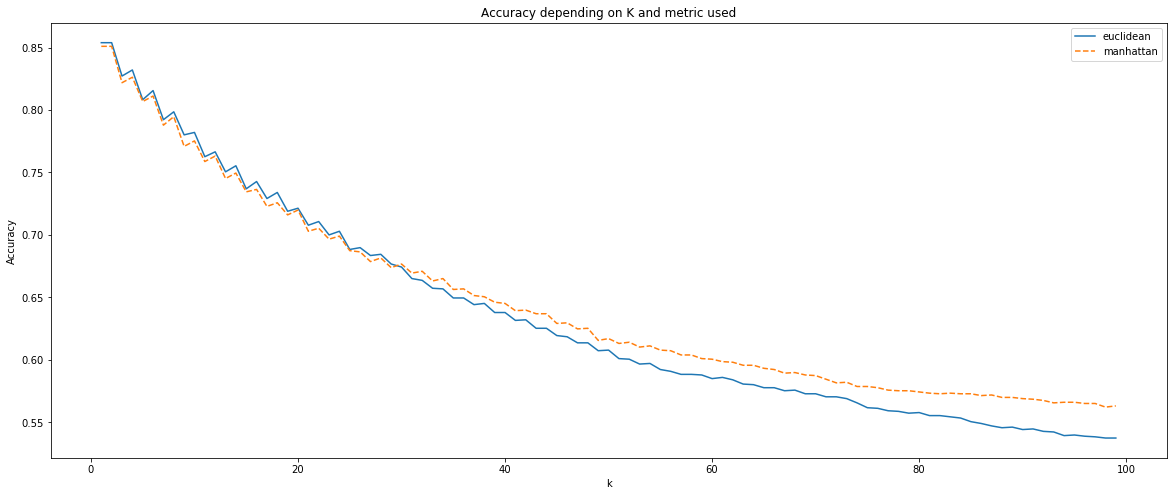

In [80]:
plt.figure(figsize=(20,8))
plt.title('Accuracy depending on K and metric used')
plt.ylabel('Accuracy')
plt.xlabel('k')
linestyles = ['-', '--', '-.', ':']

for i in range(len(df_per_metric)):
    plt.plot(df_per_metric[i]["param_n_neighbors"], df_per_metric[i]["mean_test_Accuracy"], linestyle = linestyles[i], label = metric[i])

plt.legend()
plt.show()

### save knn with best params

In [81]:
from joblib import load, dump

In [82]:
knn = KNeighborsClassifier(**grid.best_params_)

In [83]:
knn.fit(X_train.reshape(X_train.shape[:2]), y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='distance')

In [84]:
path = parentdir + "/blackbox_checkpoints/" + dataset_name + "_blackbox_knn_" + (
    time.strftime("%Y%m%d_%H%M%S") + ".joblib")
dump(knn, path) 

['/Users/francesco/github/TS_AgnosticLocalExplainer/blackbox_checkpoints/EpilepticSeizureRecognition_blackbox_knn_20200105_225631.joblib']

### load best knn

In [85]:
knn = load(parentdir + "/blackbox_checkpoints/EpilepticSeizureRecognition_blackbox_knn_20200105_225631.joblib")

In [86]:
knn.score(X_test.reshape(X_test.shape[:2]), y_test)

0.8652173913043478

In [87]:
mean_squared_error(y_test, knn.predict(X_test.reshape(X_test.shape[:2])))

0.13478260869565217

# AUTOENCODER TRAINING

In [69]:
# TENSORBOARD
# tensorboard --logdir=/tmp/autoencoder
# http://0.0.0.0:6006
# lsof -i tcp:6006 | grep -v PID | awk '{print $2}' | xargs kill

In [99]:
import autoencoders
from autoencoders import *
"""import importlib
importlib.reload(autoencoders)"""

'import importlib\nimportlib.reload(autoencoders)'

## Standard

In [134]:
params = {'input_shape': (178, 1), 
          'n_blocks': 8, 
          'latent_dim': 30, 
          'encoder_latent_layer_type': 'dense', 
          'encoder_args': {'filters': [2, 4, 8, 16, 32, 64, 128, 256], 
                           'kernel_size': [21, 18, 15, 13, 11, 8, 5, 3], 
                           'padding': 'same', 
                           'activation': 'elu', 
                           'pooling': [1, 1, 1, 1, 1, 1, 1, 1]}}

aut = Autoencoder(**params)
encoder, decoder, autoencoder = aut.build()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 178, 1)            0         
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 178, 2)            44        
_________________________________________________________________
batch_normalization_86 (Batc (None, 178, 2)            8         
_________________________________________________________________
activation_91 (Activation)   (None, 178, 2)            0         
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 178, 2)            0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 178, 4)            148       
_________________________________________________________________
batch_normalization_87 (Batc (None, 178, 4)            16  

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 178, 1)            0         
_________________________________________________________________
Encoder (Model)              (None, 30)                171787    
_________________________________________________________________
Decoder (Model)              (None, 178, 1)            270063    
Total params: 441,850
Trainable params: 439,810
Non-trainable params: 2,040
_________________________________________________________________
None


In [520]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

file_path = parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_loss:.4f}_.hdf5")

to_dict = open(parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_.txt"),"w")
to_dict.write( str(params) )
to_dict.close()

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_loss', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)
callbacks = [reduce_lr,model_checkpoint]


In [521]:
history = autoencoder.fit(X_exp_train, X_exp_train, epochs=50, validation_data=(X_exp_val, X_exp_val), verbose = 1, 
                callbacks = callbacks)

Train on 1411 samples, validate on 353 samples
Epoch 1/50
1411/1411 [==============================] - 30s 21ms/step - loss: 140.7334 - mean_squared_error: 0.2205 - val_loss: 84.6674 - val_mean_squared_error: 0.1325

Epoch 00001: val_loss improved from inf to 84.66741, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+84.6674_.hdf5
Epoch 2/50
1411/1411 [==============================] - 15s 11ms/step - loss: 59.4241 - mean_squared_error: 0.0981 - val_loss: 60.8427 - val_mean_squared_error: 0.0979

Epoch 00002: val_loss improved from 84.66741 to 60.84270, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+60.8427_.hdf5
Epoch 3/50
1411/1411 [==============================] - 16s 11ms/step - loss: 47.7815 - mean_squared_error: 0.0806 - val_loss: 50.8042 - val_mean_squared_error: 0.0836

Epoch 00003: val_loss improved from 60.84270 to 50.80422, saving model to ./autoencoder_checkpoints/HARDataset_autoe

1411/1411 [==============================] - 15s 10ms/step - loss: 18.1802 - mean_squared_error: 0.0320 - val_loss: 24.7901 - val_mean_squared_error: 0.0438

Epoch 00028: val_loss did not improve from 22.70151
Epoch 29/50
1411/1411 [==============================] - 14s 10ms/step - loss: 18.0126 - mean_squared_error: 0.0317 - val_loss: 24.4812 - val_mean_squared_error: 0.0432

Epoch 00029: val_loss did not improve from 22.70151
Epoch 30/50
1411/1411 [==============================] - 15s 10ms/step - loss: 17.8177 - mean_squared_error: 0.0313 - val_loss: 22.4595 - val_mean_squared_error: 0.0396

Epoch 00030: val_loss improved from 22.70151 to 22.45953, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+22.4595_.hdf5
Epoch 31/50
1411/1411 [==============================] - 14s 10ms/step - loss: 17.0562 - mean_squared_error: 0.0300 - val_loss: 21.3380 - val_mean_squared_error: 0.0376

Epoch 00031: val_loss improved from 22.45953 to 21.33802, sav

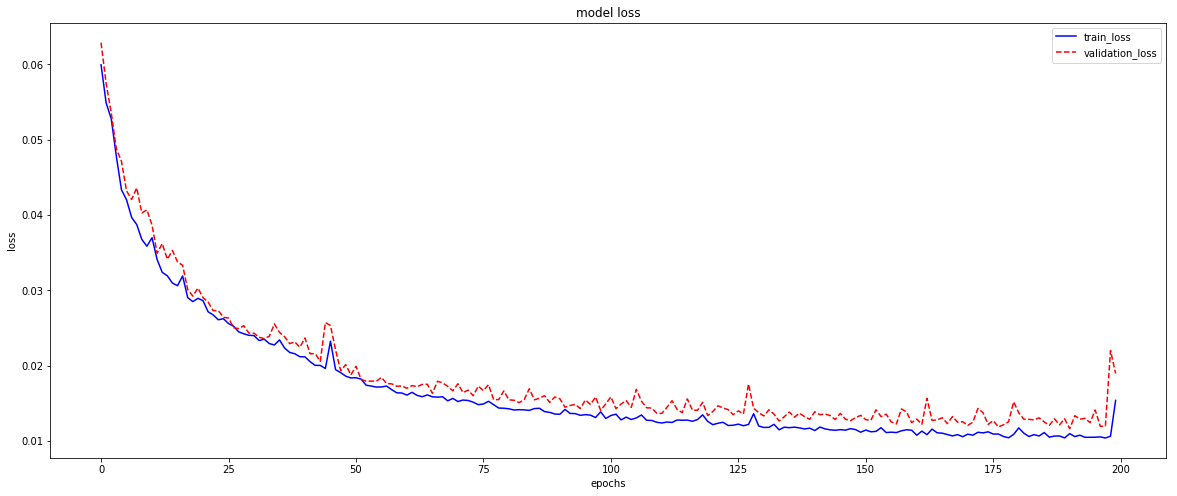

In [207]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history["loss"], color = "blue", label = "train_loss")
plt.plot(history.history["val_loss"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

In [135]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/EpilepticSeizureRecognition_autoencoder_20200106_111007_best_weights_+14872.8621_.hdf5")

In [136]:
autoencoder.evaluate(X_exp_val, X_exp_val)

177/177 [==============================] - 11s 62ms/step


14872.861802612995

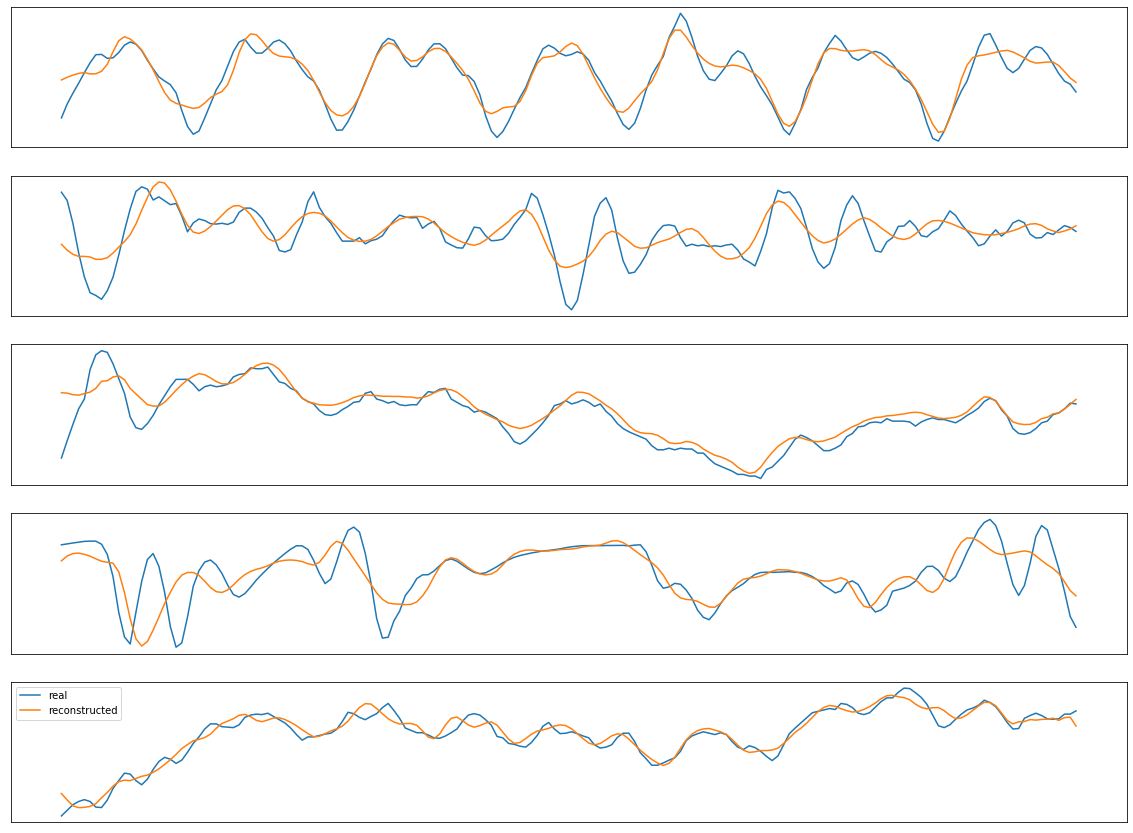

In [137]:
decoded_tss = autoencoder.predict(X_exp_val)
n = 100
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()

In [103]:
from myutils import reconstruction_blackbox_consistency

/Users/francesco/anaconda3/envs/tesi/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [138]:
reconstruction_blackbox_consistency(autoencoder, resnet, X_exp_test)

0.9547511312217195

In [139]:
reconstruction_blackbox_consistency(autoencoder, simplecnn, X_exp_test)

0.9638009049773756

In [140]:
reconstruction_blackbox_consistency(autoencoder, knn, X_exp_test, keras = False)

0.9592760180995475

## VARIATIONAL

In [141]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 30,
          "encoder_latent_layer_type": "variational",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]}
         }
aut = Autoencoder(**params)
encoder, decoder, autoencoder = aut.build()

Model: "VariationalEncoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 178, 1)       0                                            
__________________________________________________________________________________________________
conv1d_111 (Conv1D)             (None, 178, 2)       44          input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_102 (BatchN (None, 178, 2)       8           conv1d_111[0][0]                 
__________________________________________________________________________________________________
activation_109 (Activation)     (None, 178, 2)       0           batch_normalization_102[0][0]    
_________________________________________________________________________________

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 30)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 178)               5518      
_________________________________________________________________
reshape_6 (Reshape)          (None, 178, 1)            0         
_________________________________________________________________
up_sampling1d_41 (UpSampling (None, 178, 1)            0         
_________________________________________________________________
conv1d_120 (Conv1D)          (None, 178, 256)          1024      
_________________________________________________________________
batch_normalization_110 (Bat (None, 178, 256)          1024      
_________________________________________________________________
activation_118 (Activation)  (None, 178, 256)          0   

In [520]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

file_path = parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_loss:.4f}_.hdf5")

to_dict = open(parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_.txt"),"w")
to_dict.write( str(params) )
to_dict.close()

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_loss', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)
callbacks = [reduce_lr,model_checkpoint]


In [521]:
history = autoencoder.fit(X_exp_train, X_exp_train, epochs=50, validation_data=(X_exp_val, X_exp_val), verbose = 1, 
                callbacks = callbacks)

Train on 1411 samples, validate on 353 samples
Epoch 1/50
1411/1411 [==============================] - 30s 21ms/step - loss: 140.7334 - mean_squared_error: 0.2205 - val_loss: 84.6674 - val_mean_squared_error: 0.1325

Epoch 00001: val_loss improved from inf to 84.66741, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+84.6674_.hdf5
Epoch 2/50
1411/1411 [==============================] - 15s 11ms/step - loss: 59.4241 - mean_squared_error: 0.0981 - val_loss: 60.8427 - val_mean_squared_error: 0.0979

Epoch 00002: val_loss improved from 84.66741 to 60.84270, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+60.8427_.hdf5
Epoch 3/50
1411/1411 [==============================] - 16s 11ms/step - loss: 47.7815 - mean_squared_error: 0.0806 - val_loss: 50.8042 - val_mean_squared_error: 0.0836

Epoch 00003: val_loss improved from 60.84270 to 50.80422, saving model to ./autoencoder_checkpoints/HARDataset_autoe

1411/1411 [==============================] - 15s 10ms/step - loss: 18.1802 - mean_squared_error: 0.0320 - val_loss: 24.7901 - val_mean_squared_error: 0.0438

Epoch 00028: val_loss did not improve from 22.70151
Epoch 29/50
1411/1411 [==============================] - 14s 10ms/step - loss: 18.0126 - mean_squared_error: 0.0317 - val_loss: 24.4812 - val_mean_squared_error: 0.0432

Epoch 00029: val_loss did not improve from 22.70151
Epoch 30/50
1411/1411 [==============================] - 15s 10ms/step - loss: 17.8177 - mean_squared_error: 0.0313 - val_loss: 22.4595 - val_mean_squared_error: 0.0396

Epoch 00030: val_loss improved from 22.70151 to 22.45953, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+22.4595_.hdf5
Epoch 31/50
1411/1411 [==============================] - 14s 10ms/step - loss: 17.0562 - mean_squared_error: 0.0300 - val_loss: 21.3380 - val_mean_squared_error: 0.0376

Epoch 00031: val_loss improved from 22.45953 to 21.33802, sav

In [ ]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history["loss"], color = "blue", label = "train_loss")
plt.plot(history.history["val_loss"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

In [142]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/EpilepticSeizureRecognition_autoencoder_20200106_115956_best_weights_+4548653.0325_.hdf5")

In [143]:
autoencoder.evaluate(X_exp_val, X_exp_val)

177/177 [==============================] - 13s 71ms/step


[4547926.56779661, 25542.92092602401]

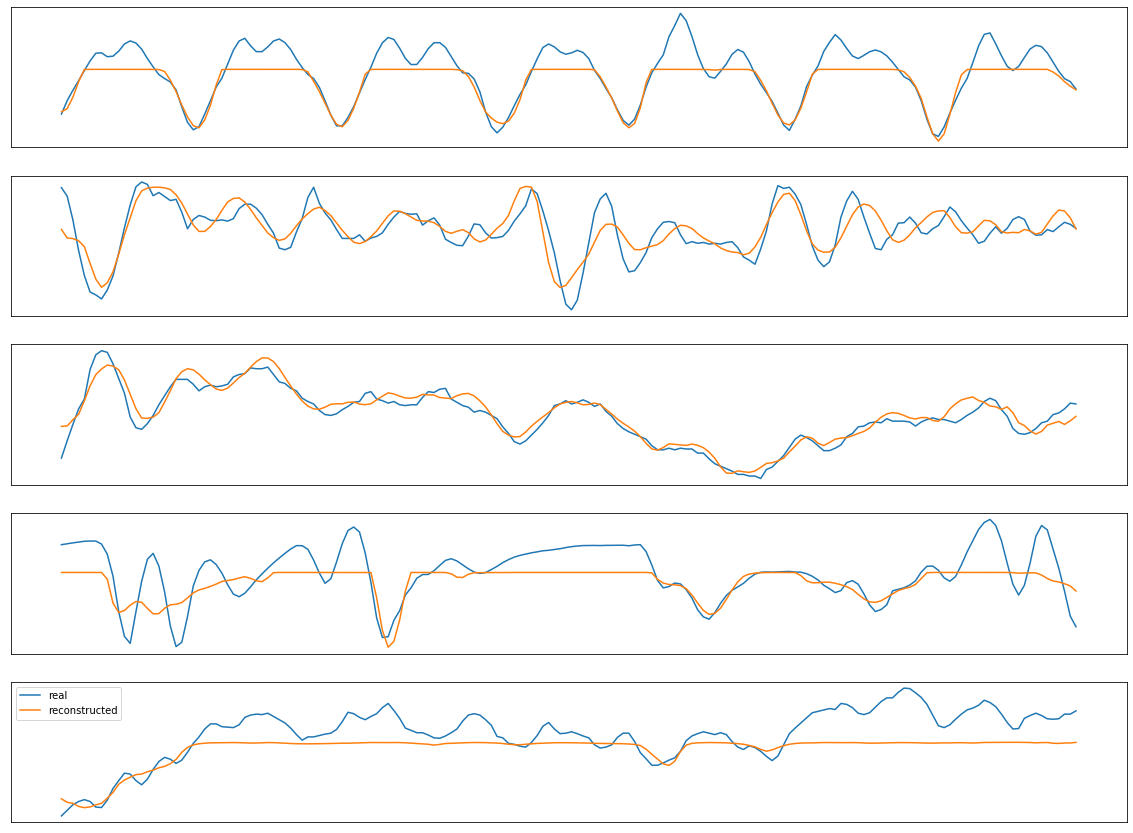

In [144]:
decoded_tss = autoencoder.predict(X_exp_val)
n = 100
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()

In [145]:
print(reconstruction_blackbox_consistency(autoencoder, resnet, X_exp_test))
print(reconstruction_blackbox_consistency(autoencoder, simplecnn, X_exp_test))
print(reconstruction_blackbox_consistency(autoencoder, knn, X_exp_test, keras = False))

0.9411764705882353
0.9592760180995475
0.8009049773755657


## Adversarial

In [146]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 30,
          "encoder_latent_layer_type": "dense",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]},
          "discriminator_args": {"units": [100,100],
                                 "activation": "relu"},
          "n_blocks_discriminator": 2}

aut = DiscriminativeAutoencoder(**params)
encoder, decoder, discriminator, autoencoder = aut.build()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 178, 1)            0         
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 178, 2)            44        
_________________________________________________________________
batch_normalization_118 (Bat (None, 178, 2)            8         
_________________________________________________________________
activation_127 (Activation)  (None, 178, 2)            0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 178, 2)            0         
_________________________________________________________________
conv1d_130 (Conv1D)          (None, 178, 4)            148       
_________________________________________________________________
batch_normalization_119 (Bat (None, 178, 4)            16  

Model: "Discriminative Autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 178, 1)       0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 30)           171787      Input[0][0]                      
__________________________________________________________________________________________________
Decoder (Model)                 (None, 178, 1)       270063      Encoder[1][0]                    
__________________________________________________________________________________________________
Discriminator (Model)           (None, 1)            13301       Encoder[1][0]                    
Total params: 455,151
Trainable params: 439,810
Non-trainable params: 15,

In [147]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/EpilepticSeizureRecognition_autoencoder_20200106_122042_best_weights_+19803.450249_.hdf5")

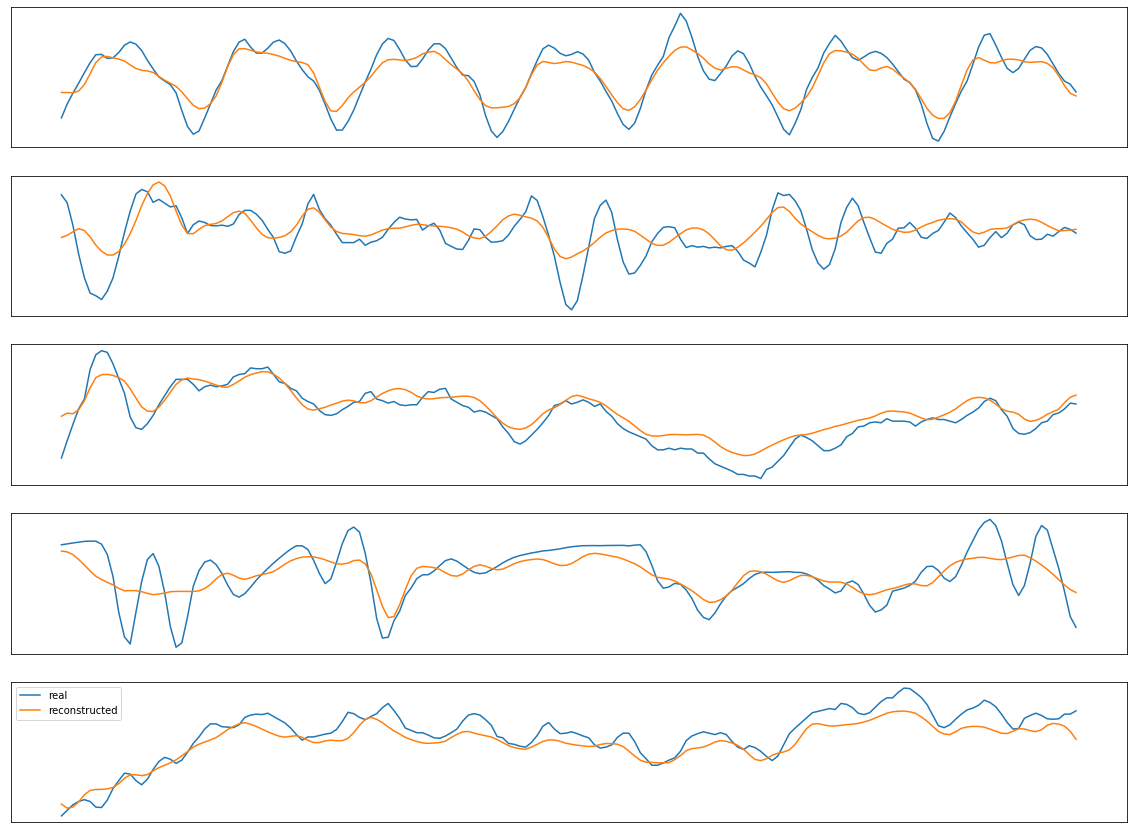

In [149]:
decoded_tss = autoencoder.predict(X_exp_val)[0]
n = 100
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()

In [ ]:
autoencoder.evaluate(X_exp_val, X_exp_val)

In [150]:
print(reconstruction_blackbox_consistency(autoencoder, resnet, X_exp_test, discriminative = True))
print(reconstruction_blackbox_consistency(autoencoder, simplecnn, X_exp_test, discriminative = True))
print(reconstruction_blackbox_consistency(autoencoder, knn, X_exp_test, keras = False, discriminative = True))

0.9230769230769231
0.9366515837104072
0.8687782805429864


## Adversarial Variational

In [151]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 30,
          "encoder_latent_layer_type": "variational",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]},
          "discriminator_args": {"units": [100,100],
                                 "activation": "relu"},
          "n_blocks_discriminator": 2}

aut = DiscriminativeAutoencoder(**params)
encoder, decoder, discriminator, autoencoder = aut.build()

Model: "VariationalEncoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 178, 1)       0                                            
__________________________________________________________________________________________________
conv1d_147 (Conv1D)             (None, 178, 2)       44          input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_134 (BatchN (None, 178, 2)       8           conv1d_147[0][0]                 
__________________________________________________________________________________________________
activation_147 (Activation)     (None, 178, 2)       0           batch_normalization_134[0][0]    
_________________________________________________________________________________

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 30)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 178)               5518      
_________________________________________________________________
reshape_8 (Reshape)          (None, 178, 1)            0         
_________________________________________________________________
up_sampling1d_57 (UpSampling (None, 178, 1)            0         
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 178, 256)          1024      
_________________________________________________________________
batch_normalization_142 (Bat (None, 178, 256)          1024      
_________________________________________________________________
activation_156 (Activation)  (None, 178, 256)          0   

In [152]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/EpilepticSeizureRecognition_autoencoder_20200106_131946_best_weights_+38381.044362_.hdf5")

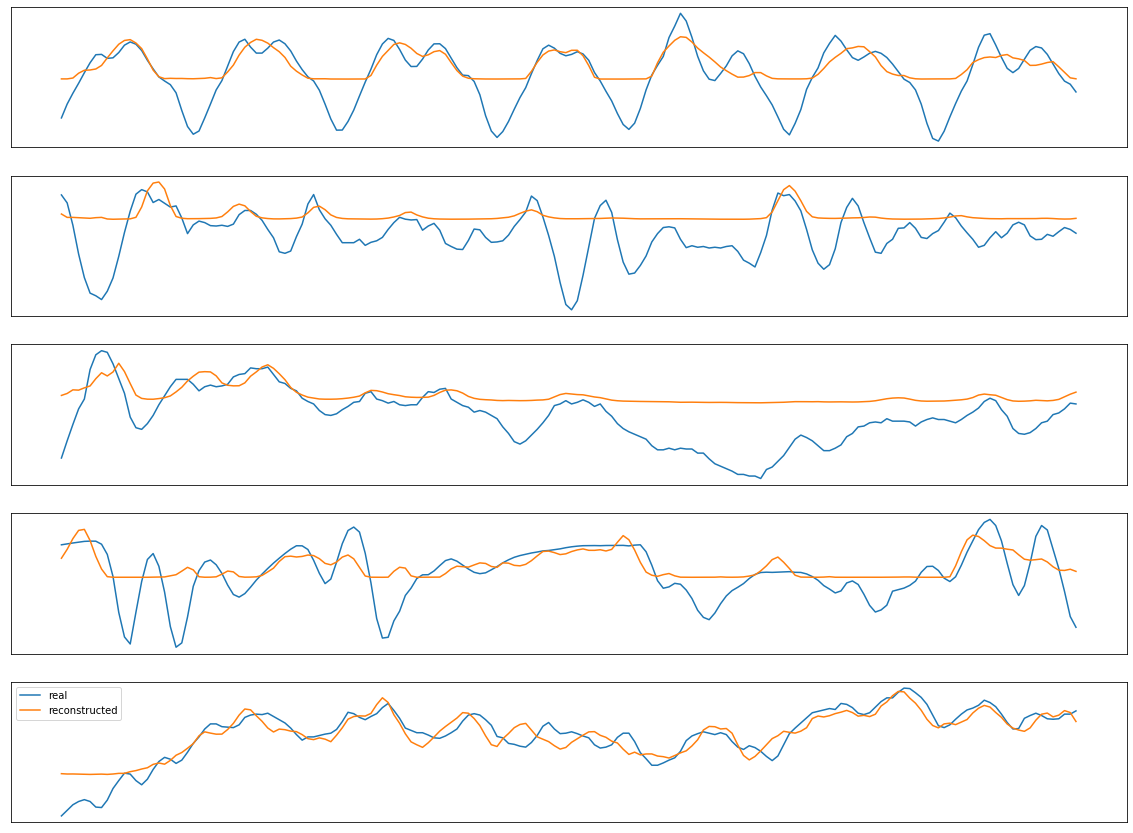

In [153]:
decoded_tss = autoencoder.predict(X_exp_val)[0]
n = 100
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()

In [154]:
print(reconstruction_blackbox_consistency(autoencoder, resnet, X_exp_test, discriminative = True))
print(reconstruction_blackbox_consistency(autoencoder, simplecnn, X_exp_test, discriminative = True))
print(reconstruction_blackbox_consistency(autoencoder, knn, X_exp_test, keras = False, discriminative = True))

0.8235294117647058
0.8235294117647058
0.665158371040724


## Standard (LSTM)

In [155]:
from toy_autoencoders import build_lstm_autoencoder
from myutils import reconstruction_blackbox_consistency

In [156]:
autoencoder = build_lstm_autoencoder(n_timesteps, 30)

In [ ]:
file_path = parentdir + "/autoencoder_checkpoints/" + dataset_name + "_lstm_autoencoder_" + (time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_loss:.6f}_.hdf5")

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                  monitor='val_loss', 
                                                  save_weights_only = True, verbose = 1,
                                                  save_best_only=True)
callbacks = [model_checkpoint]

In [ ]:
history = model.fit(X_exp_train, X_exp_train, epochs=200, validation_data=(X_exp_val, X_exp_val), verbose = 1, callbacks = callbacks)

In [162]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/EpilepticSeizureRecognition_lstm_autoencoder_20200106_142105_best_weights_+59024.272731_.hdf5")

In [163]:
reconstruction_blackbox_consistency(autoencoder, blackbox, X_exp_test)

0.502262443438914

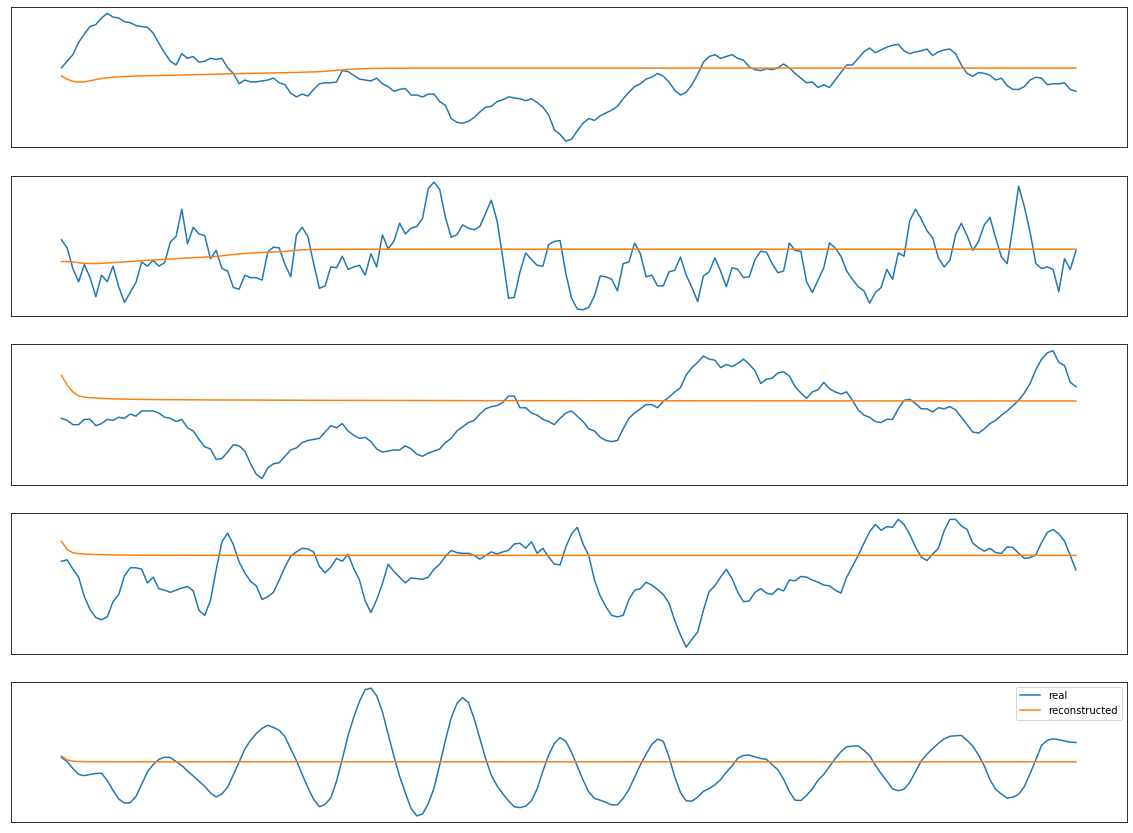

In [164]:
decoded_tss = autoencoder.predict(X_exp_val)
n = 10
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()

In [165]:
print(reconstruction_blackbox_consistency(autoencoder, resnet, X_exp_test))
print(reconstruction_blackbox_consistency(autoencoder, simplecnn, X_exp_test))
print(reconstruction_blackbox_consistency(autoencoder, knn, X_exp_test, keras = False))

0.5113122171945701
0.502262443438914
0.6018099547511312
